<a href="https://colab.research.google.com/github/floringogianu/rl-module-labs/blob/master/03_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# IMPORTANT: Run only once, no need to run it everytime you restart the runtime.
# Also important. If you hit `reset all runtimes` you need to run this cell again.
!pip uninstall gym
!pip install "gym[box2d]"

In [0]:
from argparse import Namespace
from collections import defaultdict, namedtuple
from itertools import count, product
from functools import partial
import torch.multiprocessing as mp

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
CPU_NO = mp.cpu_count()
print(f"OpenAI Gym: {gym.__version__}. \t\tShould be: ~0.15.x")
print(f"PyTorch   : {torch.__version__}.  \tShould be: >=1.2.x+cu100")
print(f"DEVICE    : {DEVICE}. \t\tWe will stick with CPU for this one.")
print(f"CPU no    : {CPU_NO}. \t\t\tShould be 2. Ideally ∞.")

OpenAI Gym: 0.15.3. 		Should be: ~0.15.x
PyTorch   : 1.3.0+cu100.  	Should be: >=1.2.x+cu100
DEVICE    : cpu. 		We will stick with CPU for this one.
CPU no    : 2. 			Should be 2. Ideally ∞.


In [0]:
LOG_INTERVAL = 10  # logging frequency

In [0]:
# Some utils
class TorchWrapper(gym.ObservationWrapper):
    """ Applies a couple of transformations depending on the mode.
        Receives numpy arrays and returns torch tensors.
    """

    def __init__(self, env, device=DEVICE):
        super().__init__(env)
        self._device = device
    
    def observation(self, obs):
        return torch.from_numpy(obs).float().unsqueeze(0).to(self._device)

# A container for statistics
StatEvent = namedtuple(
    "StatEvent",
    ["step", "episode", "reward", "running_reward", "agent", "trial"]
)

# Quick plotting
def plot_stats(stats, x="episode", y="reward", hue=None, window=10):
    df = pd.DataFrame(stats)

    if window:
        new_col = f"avg_{y}"
        if hue is not None:
            df[new_col] = (df.groupby([hue, "trial"], as_index=False)[y]
                           .rolling(window=window)
                           .mean()
                           .reset_index(0,drop=True))
        else:
            df[new_col] = df[y].rolling(window=window).mean()
    
    y = f"avg_{y}" if window else y
    with matplotlib.rc_context({'figure.figsize':(10, 6)}):
        sns.lineplot(x=x, y=y, hue=hue, data=df)

In [0]:
# Main training loop

def train(agent, env, max_episodes=400, trial=0, verbose=True):
    max_return, agent_id = env.spec.reward_threshold, type(agent).__name__
    step, stats, running_reward = 0, [], 10
 
    print("Training {0} on {1}. \nShould get about {2} points.\n".format(
        agent_id, env, max_return)
    )
    
    for episode in count(1):

        # begin episode
        state, ep_reward = env.reset().clone(), 0
        for t in range(1, 10000):
            action = agent.act(state)
            state_, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, state_, done)
            state = state_.clone()

            ep_reward += reward
            step += 1

            if done:
                break

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        stats.append(StatEvent(
            step=step,episode=episode, reward=ep_reward,
            running_reward=running_reward, agent=agent_id, trial=trial
        ))

        if episode % LOG_INTERVAL == 0:
            if verbose:
                print('Ep. {}\tAverage reward: {:.2f}'.format(
                    episode, running_reward))
        if running_reward > max_return:
            print(f"Solved! Running reward is now {running_reward:2.2f}.\n")
            break
        if episode > max_episodes:
            print(f"NOT solved! Only got {running_reward:2.2f} running reward.\n")
            break

    return StatEvent(*zip(*stats))._asdict()

### TASK 1: Implement REINFORCE


The REINFORCE Agent will receive a Policy parametrized by a torch neural network. We defined it for you below.

Notice the `forward()` method which returns a `torch.distribution` with which
you can:

- sample
- get the log probability of a sample
- compute its entropy

In [0]:
class Policy(nn.Module):
    def __init__(self, state_sz, action_num):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(state_sz, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, action_num)

    def forward(self, x):
        """ Returns a torch.distributions.Categorical object. Check the docs!
            https://pytorch.org/docs/stable/distributions.html
        """
        scores = self.affine2(F.relu(self.dropout(self.affine1(x))))
        return Categorical(F.softmax(scores, dim=1))

These agents store parts of their trajectories such as log probability of an action and rewards.

1. In the `act()` method you need to do inference through the policy and sample
an action according to resulting policy. Also it's a good place to store the
log_probability of an action.

2. Implement the `_compute_returns()` method. You need to use the rewards stored along
a trajectory to compute the discounted return:
$$
    G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}.
$$

3. Implement the `_update_policy()` method by writing down the objective:
$$
\mathcal{L}(\theta) = \mathbb{E}_{\tau \sim \pi}\left[\; \text{log} \; \pi(a_t|s_t) \; G_t\;\right]
$$

In [0]:
class Reinforce:
    def __init__(self, policy, gamma, optimizer):
        self._policy = policy
        self._gamma = gamma
        self._optimizer = optimizer
        self._fp32_err = 2e-07  # used to avoid division by 0
        self._log_probs = []    # store log pi(a|s) along a trajectory
        self._rewards = []      # store rewards along a trajectory
 
    def act(self, state):
        """ Receives a torch tensor for the current state and returns
        and action (integer).
        """
        # pi = 
        # action = 
        # log_prob a
        # return action
        pass
    
    def learn(self, state, action, reward, state_, done):
        self._rewards.append(reward)

        if done:
            self._update_policy()

    def _compute_returns(self):
        """ Use `self._rewards` to compute a vector of discounted expected
        returns.

            This function should return a tensor the size of the rewards.
        """
        # returns = 

        # Here we normalize the returns. This is a rather theoretically unsound
        # trick but it helps with the speed of convergence in this environment.
        returns = (returns - returns.mean()) / (returns.std() + self._fp32_err)

        return returns
 
    def _update_policy(self):
        # returns =

        # policy_loss = 

        self._optimizer.zero_grad()
        policy_loss.backward()
        self._optimizer.step()

        # clear the trajectories

        pass


## Training on [CartPole](https://gym.openai.com/envs/CartPole-v1/) environment.


The environment is considered solved when the average running reward is about 475.

You should be able to see the reward increase to over 200 during a limited
number of episodes, meaning the agent is learning.


![](https://keon.io/images/deep-q-learning/animation.gif)

In [0]:
max_episodes = 400  # you can increase this
gamma = 0.99
lr = 1e-2

seed = torch.randint(0, 100, (1,)).item()
torch.manual_seed(seed)
print(f"Set seed={seed}.")

env = TorchWrapper(gym.make('CartPole-v1'))
env.seed(seed)

policy = Policy(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
agent = Reinforce(policy, gamma, optim.Adam(policy.parameters(), lr=lr))

stats = train(agent, env, max_episodes=max_episodes)

Set seed=79.
Training Reinforce on <TorchWrapper<TimeLimit<CartPoleEnv<CartPole-v1>>>>. 
Should get about 475.0 points.

Ep. 10	Average reward: 17.21
Ep. 20	Average reward: 25.68
Ep. 30	Average reward: 24.49
Ep. 40	Average reward: 24.00
Ep. 50	Average reward: 22.83
Ep. 60	Average reward: 35.31
Ep. 70	Average reward: 48.76
Ep. 80	Average reward: 77.31
Ep. 90	Average reward: 99.25
Ep. 100	Average reward: 139.93
Ep. 110	Average reward: 184.75
Ep. 120	Average reward: 168.31
Ep. 130	Average reward: 145.49
Ep. 140	Average reward: 134.02
Ep. 150	Average reward: 138.70
Ep. 160	Average reward: 131.57
Ep. 170	Average reward: 218.07
Ep. 180	Average reward: 310.63
Ep. 190	Average reward: 343.08
Ep. 200	Average reward: 359.99
Ep. 210	Average reward: 407.49
Ep. 220	Average reward: 416.26
Ep. 230	Average reward: 444.10
Ep. 240	Average reward: 466.53
Solved! Running reward is now 475.40.



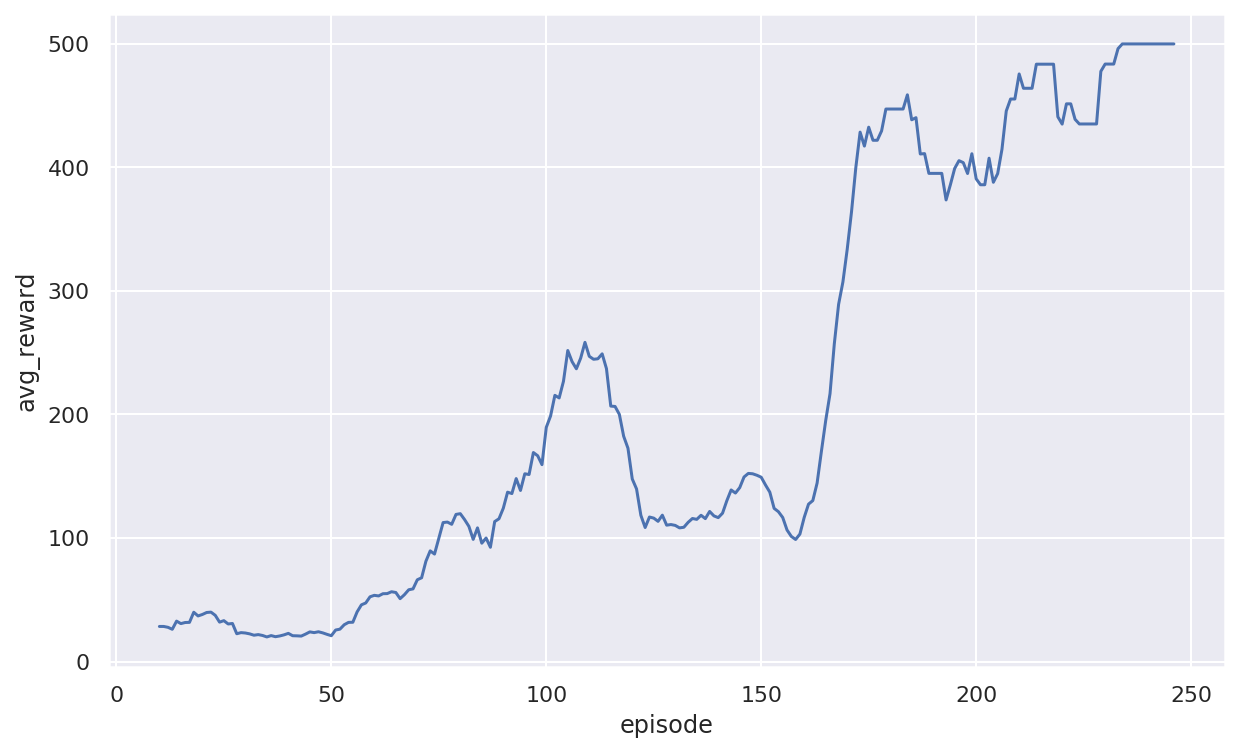

In [0]:
plot_stats(stats)

### TASK 2: Implement a REINFORCE agent with a value-function Baseline.

1. Implement the ActorCriticPolicy, following the `Policy` example but accomodating for the value function. The `forward()` method needs to 
return tuple $(\pi(\cdot | s), V(s))$.
2. Change `act()` so that the agent also stores $V(s)$.
3. Notice `_compute_returns()` does not change. However you need to make the necessary changes in `_update_policy()` so that:
    -  the value function is also updated. You can use MSE or `torch.nn.functional.smooth_l1_loss` for the value function loss. The latter is more robust to outliers.
    - you compute the corrected estimate using the baseline. Remember we can construct an estimate like this:
    
$$
    \nabla_{\theta} J(\theta) 
        = \mathbb{E}_{\pi_{\theta}}\left[\nabla_{\theta} \log \pi_{\theta}(s, a) \; (\color{#00cd00}{ G_t - V^{\pi}_{\phi}(s) }) \right]
$$

In [0]:
class ActorCriticPolicy(nn.Module):
    def __init__(self, state_sz, action_num, hidden_size=64):
        super().__init__()
        # define your model
    
    def forward(self, x):
        # do the forward pass
        return pi, value

In [0]:
class BaselineReinforce(Reinforce):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._values = []       # keeps value estimates

    def act(self, state):
        # pi = 
        # action = 
        # log_prob a
        # value
        # return action
        pass
    
    def _update_policy(self):
        """ Compute the Policy update, this time by substracting
        a baseline based on V(s).
        """
        # returns = 
        # values = 
        # log_probs =
        # advantage =

        # Compute policy and value function losses
        # policy_loss = 
        # value_loss = 

        # Backpropagate and do an optimization step
        self._optimizer.zero_grad()
        # loss = 
        loss.backward()
        self._optimizer.step()

        # Clear the stored trajectory


In [0]:
max_episodes = 300  # increase this
gamma = 0.99
lr = 1e-2

seed = torch.randint(0, 100, (1,)).item()
torch.manual_seed(seed)
print(f"Starting with seed={seed}.")

env = TorchWrapper(gym.make('CartPole-v1'))
env.seed(seed)

policy = ActorCriticPolicy(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
agent = BaselineReinforce(
    policy,
    gamma,
    optim.Adam(policy.parameters(), lr=lr)
)

stats = train(agent, env, max_episodes=max_episodes)

Starting with seed=14.
Training BaselineReinforce on <TorchWrapper<TimeLimit<CartPoleEnv<CartPole-v1>>>>. 
Should get about 475.0 points.

Ep. 10	Average reward: 12.57
Ep. 20	Average reward: 13.62
Ep. 30	Average reward: 17.07
Ep. 40	Average reward: 32.68
Ep. 50	Average reward: 48.04
Ep. 60	Average reward: 86.51
Ep. 70	Average reward: 137.86
Ep. 80	Average reward: 182.48
Ep. 90	Average reward: 200.09
Ep. 100	Average reward: 236.46
Ep. 110	Average reward: 206.54
Ep. 120	Average reward: 208.66
Ep. 130	Average reward: 274.44
Ep. 140	Average reward: 358.98
Ep. 150	Average reward: 302.57
Ep. 160	Average reward: 352.15
Ep. 170	Average reward: 364.44
Ep. 180	Average reward: 309.86
Ep. 190	Average reward: 386.16
Ep. 200	Average reward: 431.84
Ep. 210	Average reward: 459.19
Ep. 220	Average reward: 475.57
Solved! Running reward is now 475.57.



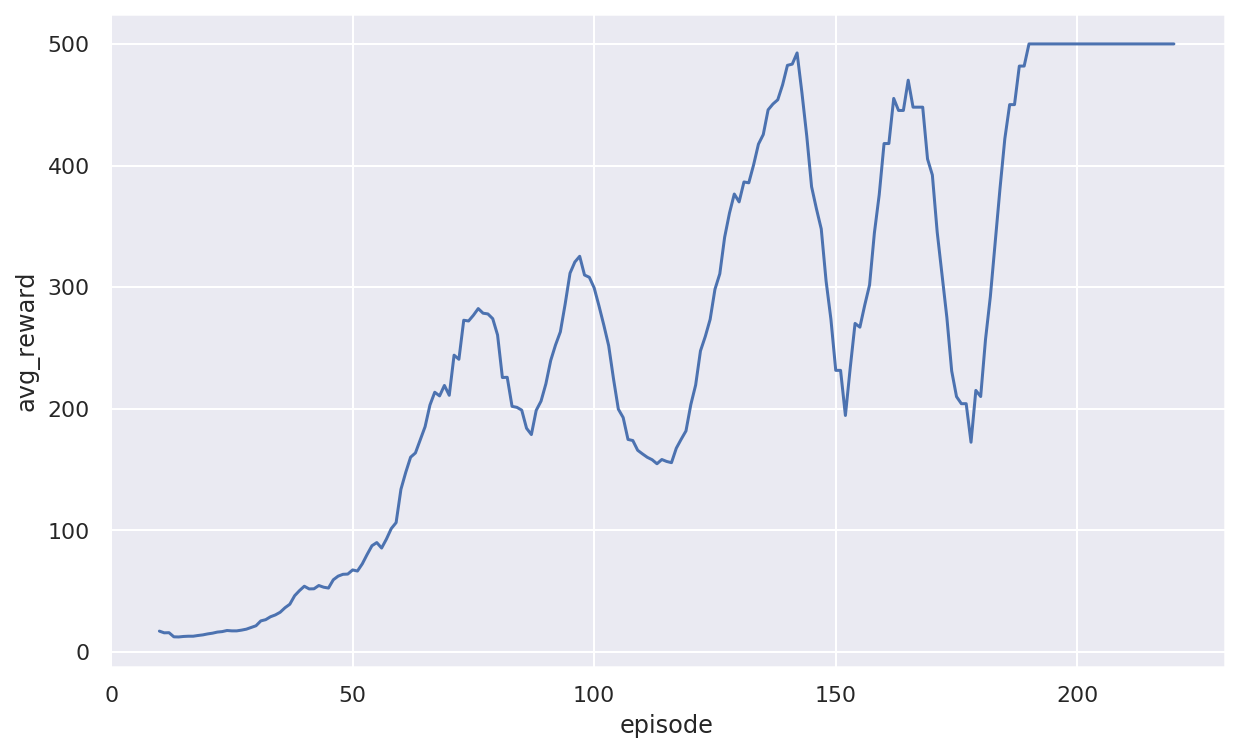

In [0]:
plot_stats(stats)

### Let's properly compare the two (You can skip this if you want).

We will compare the two algorithms. However for this to run fast we will use multiprocessing which is a _bit of a pain in notebook_. At this point you should:

1. Restart the runtime.
2. Run all the cells with all the function and class definitions **EXCEPT** those that run experiments. I have no ideea why those interact with the cell below.
3. Do the above if you notice this cell hangs, without training log output.

`colab` has only two vCores so you might do better running the multiprocessing
part of the lab on your laptops.

In [0]:
def worker(trial, seed, env_name, Agent, PI, gamma=.99, lr=1e-2):
    """ Worker which will configure and run an experiment on each process.
    """
    torch.manual_seed(seed)
    env = TorchWrapper(gym.make(env_name), device=MP_DEVICE)
    env.seed(seed)

    policy = PI(
        env.observation_space.shape[0],
        env.action_space.n
    ).to(MP_DEVICE)
    
    agent = Agent(
        policy,
        gamma,
        optim.Adam(policy.parameters(), lr=lr)
    )
    print(trial, seed, type(agent).__name__, type(policy).__name__)

    return train(agent, env, max_episodes=max_episodes, trial=trial, verbose=True)

In [0]:
MP_DEVICE = torch.device("cpu")
TRIALS = 3
env_name = "CartPole-v1"
max_episodes = 400  # increase this?

# Agent, policy, gamma, lr
config = [
    [env_name, Reinforce, Policy, 0.99, 1e-2],
    [env_name, BaselineReinforce, ActorCriticPolicy, 0.99, 1e-2]
]
seeds = [(trial, torch.randint(0, 100, (1,)).item()) for trial in range(TRIALS)]
experiments = [[*e[0], *e[1]] for e in list(product(seeds, config))]
 
 
if __name__ == "__main__":

    # Launch a couple of processes.
    with mp.Pool(CPU_NO) as p:
        all_stats = p.starmap(worker, experiments)
    
    reinforce_baseline_stats = defaultdict(list)
    for d in all_stats:
        for k, v in d.items():
            reinforce_baseline_stats[k] += v

Ep. 190	Average reward: 433.91
Ep. 380	Average reward: 365.35
Ep. 200	Average reward: 363.62
Ep. 390	Average reward: 409.30
Ep. 210	Average reward: 361.50
Ep. 220	Average reward: 271.41
Ep. 230	Average reward: 208.60
Ep. 240	Average reward: 183.60
Ep. 400	Average reward: 444.27
NOT solved! Only got 447.06 running reward.

Ep. 250	Average reward: 187.90
Ep. 260	Average reward: 247.15
Ep. 270	Average reward: 345.80
Ep. 280	Average reward: 387.40
Ep. 290	Average reward: 427.92
Ep. 300	Average reward: 456.84
Ep. 310	Average reward: 474.16
Solved! Running reward is now 475.45.



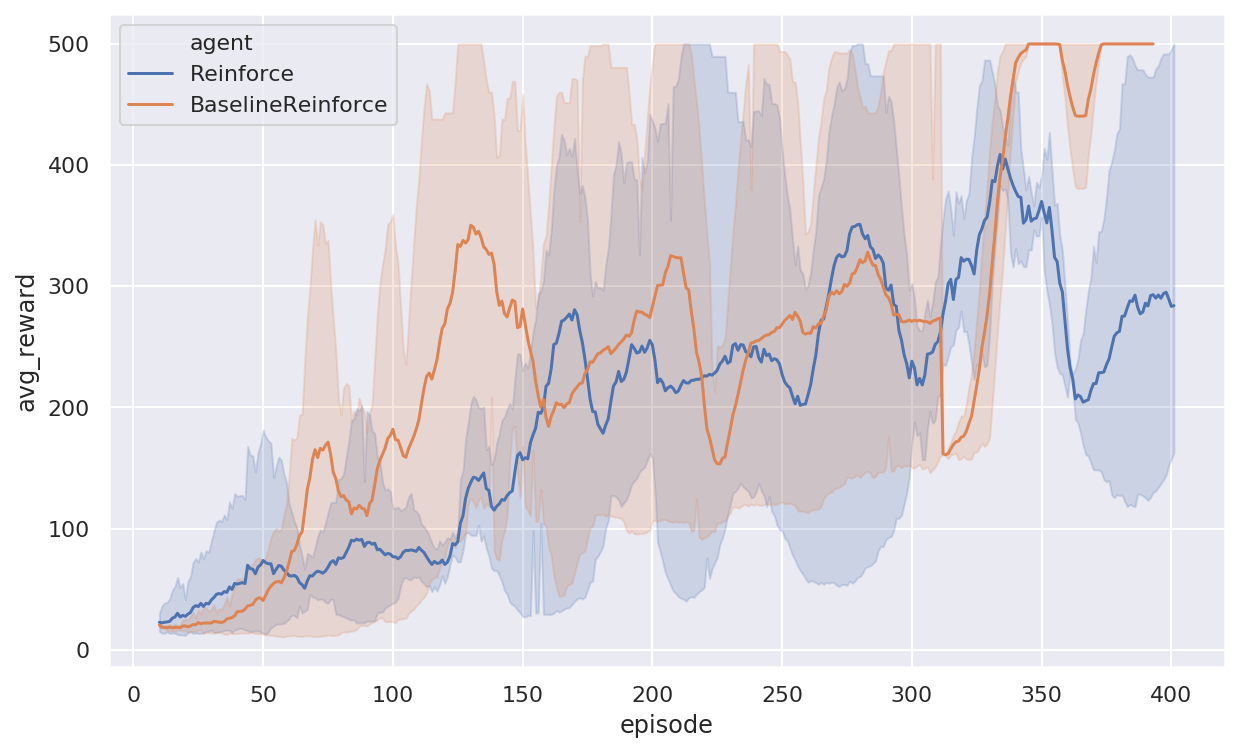

In [0]:
plot_stats(reinforce_baseline_stats, hue="agent")

In [0]:
# Uncomment this if the previous cell crashes miserably or if you can't
# make it execute.

# TRIALS = 3
# env_name = "CartPole-v1"
# max_episodes = 400  # increase this?

# # Agent, policy, gamma, lr
# config = [
#     [env_name, Reinforce, Policy, 0.99, 1e-2],
#     [env_name, BaselineReinforce, ActorCriticPolicy, 0.99, 1e-2]
# ]
# seeds = [(trial, torch.randint(0, 100, (1,)).item()) for trial in range(TRIALS)]
# experiments = [[*e[0], *e[1]] for e in list(product(seeds, config))]

# print(f"{TRIALS} trials with seeds={seeds}.")

# stats = defaultdict(list)

# for experiment in experiments:
#     stats_ = worker(*experiment)
#     for k, v in stats_.items():
#         stats[k] += v

In [0]:
# plot_stats(stats, hue="agent")

## Training on [LunarLander](https://gym.openai.com/envs/LunarLander-v2/) environment.


The environment is considered solved when the average running reward is about 200.

You should be able to see the reward increase over 0 during a limited
number of episodes, meaning the agent is learning.

This is more of a bonus, training takes long so focus on the other tasks before running this maybe.

<img src="https://miro.medium.com/max/1194/1*mGx4AWKvscx6bJony1fiag.gif" width=300px>

In [0]:
if __name__ == "__main__":
    env_name = "LunarLander-v2"
    MP_DEVICE = torch.device("cpu")
    TRIALS = 3
    max_episodes = 500  # you need at least ~800 episodes
 
    config = [
        [env_name, Reinforce, Policy, 0.99, 1e-2],
        [env_name, BaselineReinforce, ActorCriticPolicy, 0.99, 5e-3]
    ]
    seeds = [(trial, torch.randint(0, 100, (1,)).item()) for trial in range(TRIALS)]
    experiments = [[*e[0], *e[1]] for e in list(product(seeds, config))]
 

    # Launch a couple of processes.
    with mp.Pool(CPU_NO) as p:
        all_stats = p.starmap(worker, experiments)
    
    stats = defaultdict(list)
    for d in all_stats:
        for k, v in d.items():
            stats[k] += v

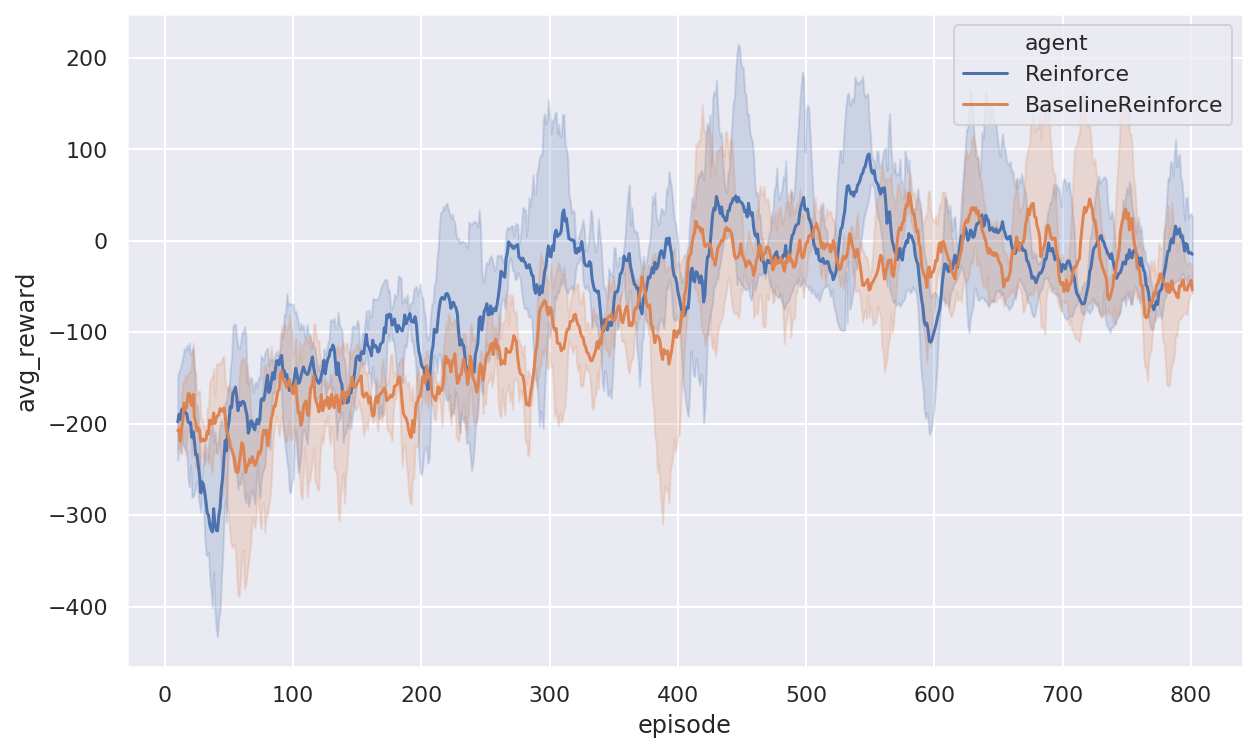

In [0]:
plot_stats(stats, hue="agent")
## you can save this for comparing it with the next algos
torch.save(stats, "./ll_reinforce.pkl")

### TASK 3: Implement Advantage Actor Critic (A2C)

You will make the necessary modifications such as to transform the REINFORCE
algorithm into an Advantage Actor Critic - A2C (without the distributed, Asynchronous part).

1. Modify the `act()` method. It's a good place to compute and store entropies.
2. Implement `_compute_returns()`. As opposed to before we now bootstrap every `nstep` on $V(s_{t+n+1})$ if the state is not terminal. Otherwize we use the last reward. Notice the signature of this method changed.
3. Modify the `update()` to account for the entropy regularization. You can use most of the previous implementation.



In [0]:
class A2C(Reinforce):
    def __init__(self, *args, nsteps=5, **kwargs):
        super().__init__(*args, **kwargs)
        self._nsteps = nsteps
        self._beta = 0.01       # beta term in entropy regularization
        self._values = []       # keeps episodic/nstep value estimates
        self._entropies = []    # keeps episodic/nstep policy entropies
        self._step_cnt = 0

    def act(self, state):
        # same as before but you also need to compute the entropy of the policy
        # return action
    
    def learn(self, state, action, reward, state_, done):
        self._rewards.append(reward)

        if done or (self._step_cnt % (self._nsteps - 1) == 0 and self._step_cnt != 0):
            self._update_policy(done, state_)

        self._step_cnt = 0 if done else self._step_cnt + 1
    
    def _compute_returns(self, done, state_):
        returns = 
        # again, the normalization step
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + self._fp32_err)
        return returns  # ఠ_ఠ
 
    def _update_policy(self, done, state_):
        # returns = 
        # values = 
        # log_probs = 
        # entropy =
        # advantage =

        # policy_loss = 
        # critic_loss = 

        self._optimizer.zero_grad()
        # loss = 
        loss.backward()
        self._optimizer.step()

        # clear trajectories


In [0]:
max_episodes = 800  # increase this
gamma = 0.99
nsteps=20
lr = 5e-3

seed = torch.randint(0, 100, (1,)).item()
torch.manual_seed(seed)
print(f"Starting with seed={seed}.")

env = TorchWrapper(gym.make('LunarLander-v2'))
env.seed(seed)

policy = ActorCriticPolicy(
    env.observation_space.shape[0],
    env.action_space.n,
    hidden_size=128).to(DEVICE)
agent = A2C(
    policy,
    gamma,
    optim.Adam(policy.parameters(), lr=lr, eps=1e-05),
    nsteps=nsteps
)

a2c_stats = train(agent, env, max_episodes=max_episodes)

Starting with seed=55.
Training A2C on <TorchWrapper<TimeLimit<LunarLander<LunarLander-v2>>>>. 
Should get about 200 points.

Ep. 10	Average reward: -112.11
Ep. 20	Average reward: -201.01
Ep. 30	Average reward: -278.11
Ep. 40	Average reward: -256.08
Ep. 50	Average reward: -161.53
Ep. 60	Average reward: -82.97
Ep. 70	Average reward: -88.64
Ep. 80	Average reward: -99.46
Ep. 90	Average reward: -54.00
Ep. 100	Average reward: -51.24
Ep. 110	Average reward: -89.44
Ep. 120	Average reward: -56.36
Ep. 130	Average reward: -82.73
Ep. 140	Average reward: -97.28
Ep. 150	Average reward: -95.47
Ep. 160	Average reward: -99.43
Ep. 170	Average reward: -48.04
Ep. 180	Average reward: -66.05
Ep. 190	Average reward: -55.11
Ep. 200	Average reward: -41.37
Ep. 210	Average reward: -60.26
Ep. 220	Average reward: -63.38
Ep. 230	Average reward: -73.35
Ep. 240	Average reward: -20.09
Ep. 250	Average reward: -22.90
Ep. 260	Average reward: -27.10
Ep. 270	Average reward: -25.44
Ep. 280	Average reward: -4.18
Ep. 290	Ave

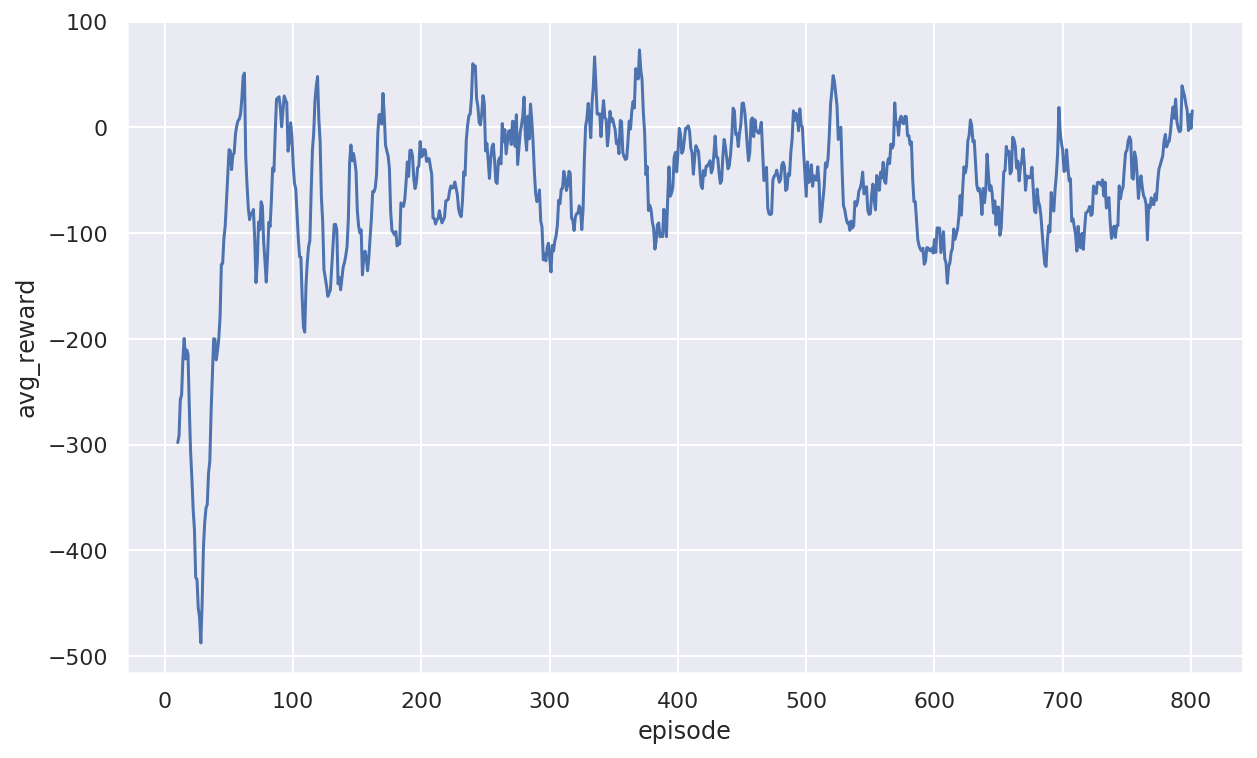

In [0]:
plot_stats(a2c_stats)

### Task 4: Implement GAE


You only need to overwrite `_compute_returns()` to return the expected returns required to compute the Generalized Advantage Estimate instead of the ordinary advantage we computed in A2C above.

$$
\begin{aligned} A_{t}^{\pi, \lambda} 
    &=(1-\lambda) \sum_{n=0}^{\infty} \lambda^{n} A_{t}^{\pi(n)} \\
    &=\sum_{t^{\prime}=t}^{\infty}(\gamma \lambda)^{t^{\prime}-t}\left(r_{t^{\prime}}+\gamma V_{\phi}\left(s_{t^{\prime}+1}\right)-V_{\phi}\left(s_{t^{\prime}}\right)\right)
\end{aligned}
$$

In [0]:
class A2CGAE(A2C):
    
    # we use `tau` instead of `lambda`.
    # don't forget to add an V(s_t). This is a bit of a hack so that we don't
    # change `update_policy()` again.
    # So you actually compute GAE and add V(s_t) to it.
    def _compute_returns(self, done, state_, tau=0.95):
        # next_value = (don't forget to detach)
        values = self._values + [next_value]
        rewards = self._rewards
        returns = []
        gae=0
        for t in reversed(range(len(rewards))):
            # stuff hapening here
            returns.insert(0, gae + values[t])

        return torch.tensor(returns)

In [0]:
max_episodes = 800  # increase this
gamma = 0.99
nsteps=30
lr = 5e-3

seed = torch.randint(0, 100, (1,)).item()
torch.manual_seed(seed)
print(f"Starting with seed={seed}.")

env = TorchWrapper(gym.make('LunarLander-v2'))
env.seed(seed)

policy = ActorCriticPolicy(
    env.observation_space.shape[0],
    env.action_space.n,
    hidden_size=64).to(DEVICE)
agent = A2CGAE(
    policy,
    gamma,
    optim.Adam(policy.parameters(), lr=lr, eps=1e-05),
    nsteps=nsteps
)

gae_stats = train(agent, env, max_episodes=max_episodes)

Starting with seed=41.
Training A2CGAE on <TorchWrapper<TimeLimit<LunarLander<LunarLander-v2>>>>. 
Should get about 200 points.

Ep. 10	Average reward: -69.78
Ep. 20	Average reward: -193.30
Ep. 30	Average reward: -227.89
Ep. 40	Average reward: -205.02
Ep. 50	Average reward: -188.82
Ep. 60	Average reward: -214.19
Ep. 70	Average reward: -176.60
Ep. 80	Average reward: -159.46
Ep. 90	Average reward: -163.27
Ep. 100	Average reward: -123.90
Ep. 110	Average reward: -106.35
Ep. 120	Average reward: -109.78
Ep. 130	Average reward: -122.60
Ep. 140	Average reward: -123.00
Ep. 150	Average reward: -64.59
Ep. 160	Average reward: -50.90
Ep. 170	Average reward: -42.53
Ep. 180	Average reward: -49.29
Ep. 190	Average reward: -40.87
Ep. 200	Average reward: -48.78
Ep. 210	Average reward: -39.41
Ep. 220	Average reward: -40.14
Ep. 230	Average reward: -46.77
Ep. 240	Average reward: -48.11
Ep. 250	Average reward: -52.52
Ep. 260	Average reward: -44.94
Ep. 270	Average reward: -34.91
Ep. 280	Average reward: -30.16

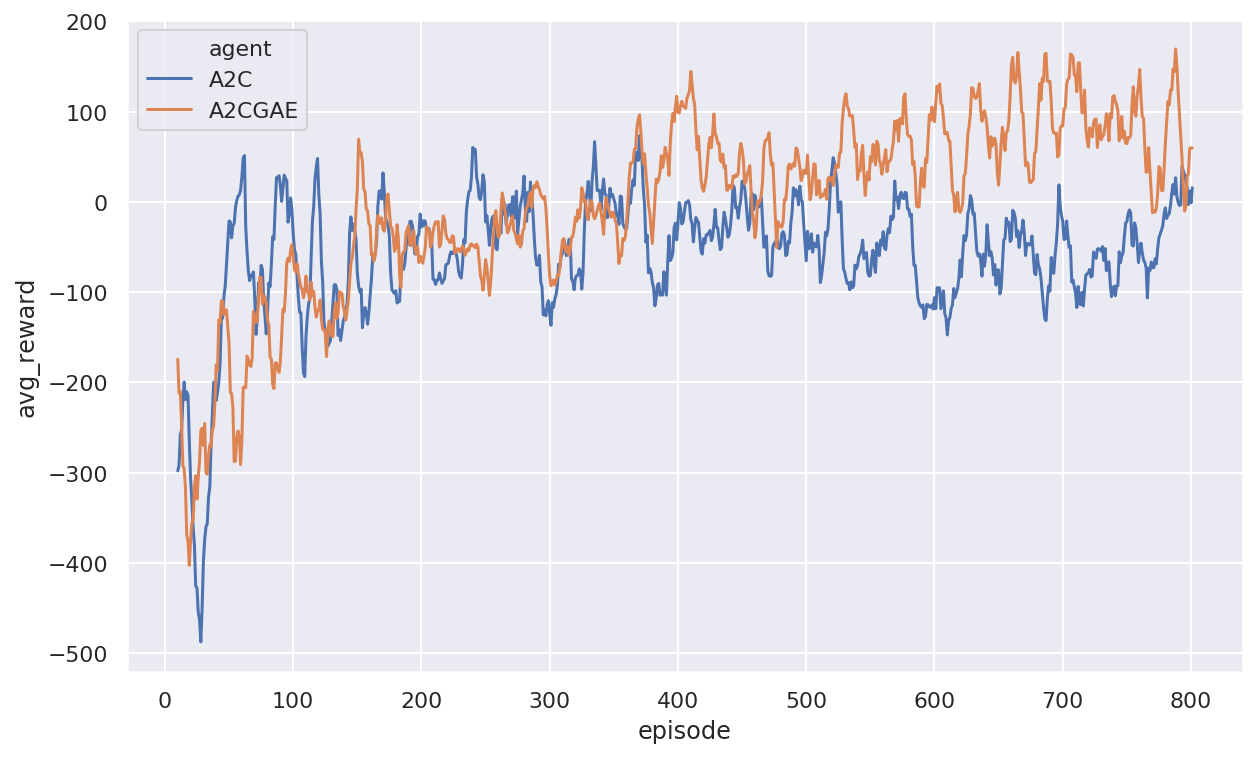

In [0]:
stats = {k: a2c_stats[k] + gae_stats[k] for k in a2c_stats.keys()}
plot_stats(stats, hue="agent")

### Again, you can do a full comparison but it will take some time.

In [0]:
if __name__ == "__main__":
    env_name = "LunarLander-v2"
    MP_DEVICE = torch.device("cpu")
    TRIALS = 3
    max_episodes = 800  # you need at least ~800 episodes
    nsteps = 30
 
    config = [
        [env_name, partial(A2C, nsteps=nsteps), ActorCriticPolicy, 0.99, 5e-3],
        [env_name, partial(A2CGAE, nsteps=nsteps), ActorCriticPolicy, 0.99, 5e-3]
    ]
    seeds = [(trial, torch.randint(0, 100, (1,)).item()) for trial in range(TRIALS)]
    experiments = [[*e[0], *e[1]] for e in list(product(seeds, config))]
 

    # Launch a couple of processes.
    with mp.Pool(CPU_NO) as p:
        all_stats = p.starmap(worker, experiments)
    
    stats = defaultdict(list)
    for d in all_stats:
        for k, v in d.items():
            stats[k] += v

0 47 A2C ActorCriticPolicy
0 47 A2CGAE ActorCriticPolicy
Training A2C on <TorchWrapper<TimeLimit<LunarLander<LunarLander-v2>>>>. 
Should get about 200 points.

Training A2CGAE on <TorchWrapper<TimeLimit<LunarLander<LunarLander-v2>>>>. 
Should get about 200 points.

Ep. 10	Average reward: -140.83
Ep. 10	Average reward: -81.89
Ep. 20	Average reward: -257.50
Ep. 20	Average reward: -189.16
Ep. 30	Average reward: -328.07
Ep. 30	Average reward: -155.52
Ep. 40	Average reward: -306.01
Ep. 40	Average reward: -150.20
Ep. 50	Average reward: -283.41
Ep. 50	Average reward: -178.51
Ep. 60	Average reward: -317.88
Ep. 60	Average reward: -151.86
Ep. 70	Average reward: -303.24
Ep. 70	Average reward: -158.87
Ep. 80	Average reward: -226.30
Ep. 80	Average reward: -113.80
Ep. 90	Average reward: -200.52
Ep. 90	Average reward: -110.79
Ep. 100	Average reward: -82.78
Ep. 100	Average reward: -181.39
Ep. 110	Average reward: -136.62
Ep. 110	Average reward: -63.17
Ep. 120	Average reward: -152.93
Ep. 120	Average rew

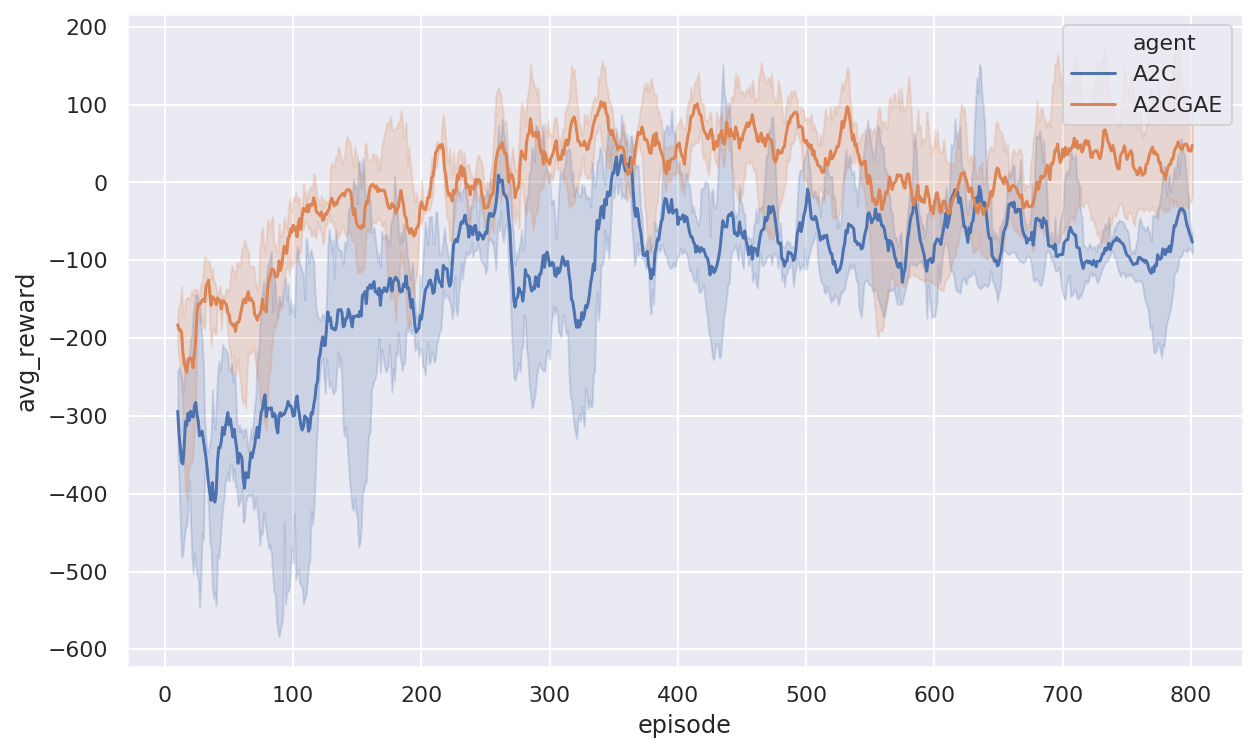

In [0]:
plot_stats(stats, hue="agent")

You can also load the pickle we saved earlier and compare the results between all the four algorithms. Just add the values of that dict into `stats` above and plot.